# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import os
import math
import pandas as pd
import numpy as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot as plt

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch library
#
import torch
import torch.nn as nn




import pytorch_forecasting 
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.data.encoders import TorchNormalizer
from pytorch_forecasting.metrics import * # SMAPE, PoissonLoss, QuantileLoss




import pytorch_lightning as pl
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters




In [3]:
print('Pytorch version:', torch.__version__)
print('Pytorch-Light version:', pl.__version__)
print('Pytorch_forecasting version:', pytorch_forecasting.__version__)

# select device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Device:', device)

Pytorch version: 1.7.0
Pytorch-Light version: 1.3.5
Pytorch_forecasting version: 0.9.0
Device: cuda


In [4]:
if (torch.cuda.is_available() == True):
    print('[INFO] CUDA is available')
    
    torch.cuda.set_device( 1 )
    print('[INFO] Device name: %s' % torch.cuda.get_device_name(0))    
else:
    print('[INFO] CUDA is not available')

[INFO] CUDA is available
[INFO] Device name: Quadro GV100


# Import data

## Load data

In [5]:
df = pd.read_csv('Data/Temperature.csv')

# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

df["const"]    = 2
df['time_idx'] = df.index 

# Set index
#
df.set_index('Date', inplace=True)


# Feature from Date/Time
#
df['Minute']     = df.index.minute
df['Hour']       = df.index.hour
# df['Day']        = df.index.day
# df['Wday']       = df.index.dayofweek 
# df['is_weekend'] = np.where(df.index.weekday.isin([5,6]), 1, 0)
#
#
print('Number of instances: ', df.shape[0])


# fix dtypes --> 'categ'
df['const']      = df['const'].astype('category')
df['Minute']     = df['Minute'].astype(str).astype('category')
df['Hour']       = df['Hour'].astype(str).astype('category')
# df['Day']        = df['Day'].astype(str).astype('category')
# df['Wday']       = df['Wday'].astype(str).astype('category')
# df['is_weekend'] = df['is_weekend'].astype(str).astype('category')

df.info()

Number of instances:  9752
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9752 entries, 2015-02-11 14:48:00 to 2015-02-18 09:19:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Temperature  9752 non-null   float64 
 1   const        9752 non-null   category
 2   time_idx     9752 non-null   int64   
 3   Minute       9752 non-null   category
 4   Hour         9752 non-null   category
dtypes: category(3), float64(1), int64(1)
memory usage: 261.0 KB


## Visualize data

In [6]:
df.head( 5 )

,Temperature,const,time_idx,Minute,Hour
Date,,,,,
2015-02-11 14:48:00,21.7600,2,0,48,14
2015-02-11 14:49:00,21.7900,2,1,49,14
2015-02-11 14:50:00,21.7675,2,2,50,14
2015-02-11 14:51:00,21.7675,2,3,51,14
2015-02-11 14:52:00,21.7900,2,4,52,14


## Split Training/Testining

# Create TimeSeriesDataSets

In [7]:
# Create training/testing datasets
#
idx = int( df.shape[0] * 0.9)

df_train = df.iloc[ :idx ]
df_test  = df.iloc[ idx: ]

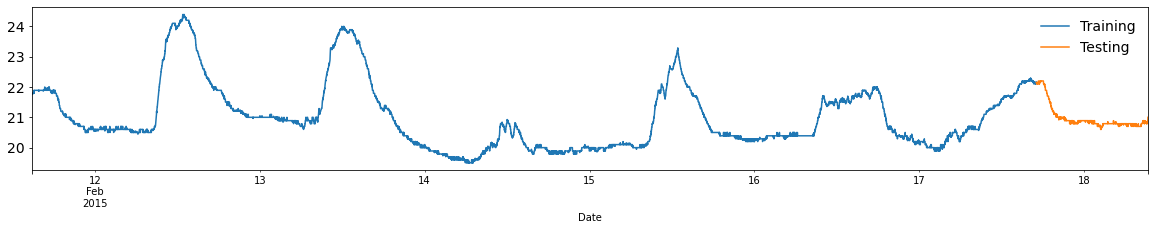

In [8]:
# Plot data
#
fig, ax = plt.subplots( figsize=(20, 3) );

df_train['Temperature'].plot(ax=ax);
df_test['Temperature'].plot(ax=ax);

plt.legend(['Training', 'Testing'], fontsize=14, frameon=False);
plt.xticks(size=14);
plt.yticks(size=14);

In [9]:
config = {'max_encoder_length'   :  96,
          'min_prediction_length':  12,
          'max_prediction_length':  12,
          'batch size'           :  32,
          'n_workers'            :   0,
          'seed'                 :  42}
    
    
training_cutoff_idx = df_train.time_idx.max() - 300 # CFG.max_prediction_length

## TimeSeriesDataSet: Training

In [10]:
train_ds = TimeSeriesDataSet(
    df_train[lambda x: x.time_idx <= training_cutoff_idx],
    #
    time_idx  = 'time_idx',
    target    = 'Temperature',
    group_ids = ['const'],  
    max_encoder_length    = config['max_encoder_length'],
    max_prediction_length = config['max_prediction_length'],
    min_prediction_length = config['min_prediction_length'],
    #
    #
    # Selected Variables
    static_categoricals               = [],  
    static_reals                      = [],
    time_varying_known_categoricals   = ['Minute', 'Hour'],
    time_varying_known_reals          = [],
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals        = ['Temperature'],       
    #
    predict_mode   = False,
    target_normalizer= TorchNormalizer(method='standard'),        
#     categorical_encoders={
#         '__group_id__const': NaNLabelEncoder(add_nan=True),
#         'Day': NaNLabelEncoder(add_nan=True),
#         'Month': NaNLabelEncoder(add_nan=True),
#     }, 
    scalers={
        'usage'     : TorchNormalizer(method='standard'),
        'time_idx'  : TorchNormalizer(method='standard'),
        'Minute'    : TorchNormalizer(method='standard'),
        'Hour'      : TorchNormalizer(method='standard'),
    }
)


train_ds.get_parameters()

{'time_idx': 'time_idx',
 'target': 'Temperature',
 'group_ids': ['const'],
 'weight': None,
 'max_encoder_length': 96,
 'min_encoder_length': 96,
 'min_prediction_idx': 0,
 'min_prediction_length': 12,
 'max_prediction_length': 12,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': ['Minute', 'Hour'],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['Temperature'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': TorchNormalizer(),
 'categorical_encoders': {'__group_id__const': NaNLabelEncoder(),
  'Minute': NaNLabelEncoder(),
  'Hour': NaNLabelEncoder()},
 'scalers': {'usage': TorchNormalizer(),
  'time_idx': TorchNormalizer(),
  'Minute': TorchNormalizer(),
  'Hour': TorchNormalizer()},
 'randomize_length': None,
 'predict_mode

## TimeSeriesDataSet: Validation

In [11]:
# create validation set (predict=True)
#
valid_ds = TimeSeriesDataSet.from_dataset(dataset            = train_ds, 
                                          data               = df_train, #[lambda x: x.time_idx > training_cutoff_idx],
                                          predict            = True, 
                                          stop_randomization = True,
                                          )

## Data Loaders

In [12]:
train_dataloader = train_ds.to_dataloader(train       = True,  
                                          batch_size  = config['batch size'], 
                                          num_workers = config['n_workers']) 

valid_dataloader = valid_ds.to_dataloader(train       = False, 
                                          batch_size  = config['batch size'], 
                                          num_workers = config['n_workers']) 

# Hyperparameter optimization

In [13]:
# tune
study = optimize_hyperparameters(train_dataloader             = train_dataloader,
                                 val_dataloader               = valid_dataloader,
                                 model_path                   = "optuna_test",
                                 n_trials                     = 200,
                                 max_epochs                   = 50,
                                 gradient_clip_val_range      = (0.01, 1.0),
                             
                                 #
                                 hidden_size_range            = (8, 128),
                                 hidden_continuous_size_range = (8, 128),
                                 attention_head_size_range    = (1, 4),
                                 learning_rate_range          = (0.001, 0.1),
                                 dropout_range                = (0.1, 0.3),
                                 trainer_kwargs               = dict(limit_train_batches = 30),
                                 reduce_on_plateau_patience   = 10,
                                 use_learning_rate_finder     = True)    

[I 2021-11-07 20:35:49,314] A new study created in memory with name: no-name-f55f24e8-53e0-4fcb-957f-4a3a54341eba
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:36:05,475] Using learning rate of 0.0363
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:38:55,082] Trial 0 finished with value: 0.016583077609539032 and parameters: {'gradient_clip_val': 0.024875069978036606, 'hidden_size': 10, 'dropout': 0.10426113031140134, 'hidden_continuous_size': 9, 'attention_head_size': 4, 'learning_rate': 0.036307805477010145}. Best is trial 0 with value: 0.016583077609539032.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:39:06,161] Using learning rate of 0.00912
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:41:50,381] Trial 1 finished with value: 0.024632783606648445 and parameters: {'gradient_clip_val': 0.8238724755343941, 'hidden_size': 61, 'dropout': 0.19232272325511618, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.009120108393559097}. Best is trial 0 with value: 0.016583077609539032.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:42:01,740] Using learning rate of 0.0417
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:42:08,307] Trial 2 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:42:20,027] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:42:27,156] Trial 3 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:42:38,642] Using learning rate of 0.0302
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:42:45,646] Trial 4 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:42:57,103] Using learning rate of 0.0331
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:43:04,123] Trial 5 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:43:15,284] Using learning rate of 0.024
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:43:22,173] Trial 6 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:43:33,975] Using learning rate of 0.00955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:43:41,053] Trial 7 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:43:52,613] Using learning rate of 0.0209
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:43:59,599] Trial 8 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:44:11,609] Using learning rate of 0.00437
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:44:18,825] Trial 9 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:44:29,520] Using learning rate of 0.0457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:44:36,121] Trial 10 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:44:47,711] Using learning rate of 0.00955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:47:34,411] Trial 11 finished with value: 0.02960471250116825 and parameters: {'gradient_clip_val': 0.03807141517136669, 'hidden_size': 123, 'dropout': 0.14253333872738083, 'hidden_continuous_size': 106, 'attention_head_size': 1, 'learning_rate': 0.009549925860214359}. Best is trial 0 with value: 0.016583077609539032.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:47:46,084] Using learning rate of 0.0158
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:47:53,004] Trial 12 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:48:04,200] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:48:10,985] Trial 13 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:48:22,452] Using learning rate of 0.0437
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:48:29,342] Trial 14 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:48:40,681] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:48:47,167] Trial 15 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:48:59,027] Using learning rate of 0.00832
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:49:05,877] Trial 16 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:49:17,048] Using learning rate of 0.0174
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:49:23,840] Trial 17 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:49:35,439] Using learning rate of 0.0955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:49:42,336] Trial 18 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:49:53,590] Using learning rate of 0.038
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:50:00,512] Trial 19 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:50:12,556] Using learning rate of 0.0692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:50:19,799] Trial 20 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:50:30,618] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:50:37,033] Trial 21 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:50:47,171] Using learning rate of 0.0138
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:51:40,566] Trial 22 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:51:51,093] Using learning rate of 0.00832
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:52:06,827] Trial 23 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:52:17,578] Using learning rate of 0.00575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:52:23,989] Trial 24 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:52:34,753] Using learning rate of 0.0191
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:52:41,245] Trial 25 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:52:51,814] Using learning rate of 0.02
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:53:07,490] Trial 26 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:53:18,110] Using learning rate of 0.0138
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:55:54,177] Trial 27 finished with value: 0.011328361928462982 and parameters: {'gradient_clip_val': 0.06704468669043331, 'hidden_size': 61, 'dropout': 0.1654581078290549, 'hidden_continuous_size': 15, 'attention_head_size': 2, 'learning_rate': 0.013803842646028847}. Best is trial 27 with value: 0.011328361928462982.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:56:04,802] Using learning rate of 0.00316
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:56:11,213] Trial 28 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:56:21,993] Using learning rate of 0.00166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:56:28,476] Trial 29 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:56:39,216] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:56:45,600] Trial 30 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:56:55,997] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:57:02,360] Trial 31 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:57:12,711] Using learning rate of 0.0288
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:57:28,207] Trial 32 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:57:38,932] Using learning rate of 0.0219
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:57:54,987] Trial 33 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:58:05,451] Using learning rate of 0.0251
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:58:11,693] Trial 34 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:58:22,235] Using learning rate of 0.02
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:58:28,567] Trial 35 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:58:39,531] Using learning rate of 0.0275
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:58:46,055] Trial 36 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:58:57,085] Using learning rate of 0.0347
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:59:03,696] Trial 37 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:59:13,774] Using learning rate of 0.0525
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:59:19,903] Trial 38 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:59:30,531] Using learning rate of 0.0191
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:59:36,892] Trial 39 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 20:59:47,835] Using learning rate of 0.0158
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 20:59:54,410] Trial 40 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:00:05,023] Using learning rate of 0.00912
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:00:20,878] Trial 41 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:00:31,756] Using learning rate of 0.00603
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:00:38,120] Trial 42 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:00:48,649] Using learning rate of 0.024
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:01:04,388] Trial 43 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:01:14,435] Using learning rate of 0.0457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:01:20,372] Trial 44 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:01:30,389] Using learning rate of 0.0158
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:01:36,653] Trial 45 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:01:47,391] Using learning rate of 0.00166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:01:53,812] Trial 46 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:02:04,171] Using learning rate of 0.024
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:02:10,362] Trial 47 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:02:20,836] Using learning rate of 0.0038
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:02:27,121] Trial 48 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:02:37,958] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:02:44,452] Trial 49 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:02:55,297] Using learning rate of 0.0138
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:03:01,919] Trial 50 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:03:12,393] Using learning rate of 0.00955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:03:18,701] Trial 51 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:03:29,243] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:03:35,615] Trial 52 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:03:46,200] Using learning rate of 0.0209
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:04:01,828] Trial 53 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:04:12,267] Using learning rate of 0.0145
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:04:18,504] Trial 54 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:04:28,889] Using learning rate of 0.0132
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:04:35,099] Trial 55 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:04:45,553] Using learning rate of 0.0138
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:04:51,885] Trial 56 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:05:02,453] Using learning rate of 0.0145
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:05:08,826] Trial 57 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:05:18,844] Using learning rate of 0.0955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:05:24,981] Trial 58 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:05:35,931] Using learning rate of 0.00955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:05:42,293] Trial 59 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:05:53,363] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:06:09,593] Trial 60 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:06:20,092] Using learning rate of 0.00182
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:06:26,034] Trial 61 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:06:36,888] Using learning rate of 0.0288
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:06:52,645] Trial 62 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:07:02,970] Using learning rate of 0.00331
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:07:09,306] Trial 63 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:07:19,815] Using learning rate of 0.00912
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:07:35,491] Trial 64 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:07:45,820] Using learning rate of 0.02
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:07:52,124] Trial 65 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:08:02,806] Using learning rate of 0.011
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:08:09,358] Trial 66 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:08:19,829] Using learning rate of 0.00166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:08:26,325] Trial 67 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:08:37,046] Using learning rate of 0.0151
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:08:43,518] Trial 68 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:08:54,153] Using learning rate of 0.0174
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:09:46,845] Trial 69 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:09:57,527] Using learning rate of 0.0151
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:10:03,866] Trial 70 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:10:14,476] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:10:20,794] Trial 71 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:10:31,361] Using learning rate of 0.0145
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:13:05,809] Trial 72 finished with value: 0.018285909667611122 and parameters: {'gradient_clip_val': 0.036669308068702985, 'hidden_size': 78, 'dropout': 0.15698472159640162, 'hidden_continuous_size': 16, 'attention_head_size': 1, 'learning_rate': 0.014454397707459272}. Best is trial 27 with value: 0.011328361928462982.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:13:16,232] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:14:09,208] Trial 73 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:14:19,747] Using learning rate of 0.0126
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:14:35,310] Trial 74 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:14:45,929] Using learning rate of 0.0132
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:14:52,277] Trial 75 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:15:02,451] Using learning rate of 0.00832
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:15:09,006] Trial 76 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:15:19,700] Using learning rate of 0.00759
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:15:25,952] Trial 77 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:15:36,877] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:15:43,220] Trial 78 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:15:53,622] Using learning rate of 0.00575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:15:59,915] Trial 79 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:16:10,679] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:16:16,956] Trial 80 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:16:27,048] Using learning rate of 0.0158
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:16:33,346] Trial 81 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:16:43,139] Using learning rate of 0.0158
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:16:49,342] Trial 82 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:16:59,684] Using learning rate of 0.00832
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:17:06,060] Trial 83 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:17:16,489] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:17:22,874] Trial 84 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:17:33,244] Using learning rate of 0.0174
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:17:39,508] Trial 85 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:17:49,993] Using learning rate of 0.00692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:17:56,515] Trial 86 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:18:06,949] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:18:13,302] Trial 87 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:18:23,477] Using learning rate of 0.0501
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:18:29,657] Trial 88 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:18:40,163] Using learning rate of 0.00955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:18:46,391] Trial 89 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:18:56,605] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:19:02,565] Trial 90 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:19:13,063] Using learning rate of 0.0209
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:19:28,718] Trial 91 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:19:39,226] Using learning rate of 0.0055
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:22:15,255] Trial 92 finished with value: 0.01815727725625038 and parameters: {'gradient_clip_val': 0.7835993856977032, 'hidden_size': 115, 'dropout': 0.13374118229250692, 'hidden_continuous_size': 106, 'attention_head_size': 1, 'learning_rate': 0.0054954087385762455}. Best is trial 27 with value: 0.011328361928462982.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:22:26,213] Using learning rate of 0.00457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:25:07,158] Trial 93 finished with value: 0.014347433112561703 and parameters: {'gradient_clip_val': 0.7382289218137034, 'hidden_size': 116, 'dropout': 0.13507649305242095, 'hidden_continuous_size': 106, 'attention_head_size': 1, 'learning_rate': 0.00457088189614875}. Best is trial 27 with value: 0.011328361928462982.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:25:17,788] Using learning rate of 0.00479
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:25:24,266] Trial 94 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:25:34,893] Using learning rate of 0.00398
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:28:10,751] Trial 95 finished with value: 0.013973030261695385 and parameters: {'gradient_clip_val': 0.753827873918342, 'hidden_size': 127, 'dropout': 0.11060464138980206, 'hidden_continuous_size': 88, 'attention_head_size': 1, 'learning_rate': 0.0039810717055349725}. Best is trial 27 with value: 0.011328361928462982.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:28:21,321] Using learning rate of 0.00661
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:29:14,163] Trial 96 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:29:24,745] Using learning rate of 0.00363
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:30:18,052] Trial 97 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:30:29,236] Using learning rate of 0.00363
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:30:35,906] Trial 98 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:30:46,662] Using learning rate of 0.00417
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:30:53,291] Trial 99 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:31:03,923] Using learning rate of 0.00331
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:31:10,358] Trial 100 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:31:20,922] Using learning rate of 0.00832
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:31:35,806] Trial 101 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:31:46,376] Using learning rate of 0.0038
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:31:52,388] Trial 102 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:32:02,646] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:32:08,751] Trial 103 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:32:19,489] Using learning rate of 0.00437
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:32:25,863] Trial 104 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:32:36,128] Using learning rate of 0.00347
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:32:42,638] Trial 105 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:32:53,338] Using learning rate of 0.00437
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:32:58,882] Trial 106 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:33:09,413] Using learning rate of 0.00219
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:33:15,428] Trial 107 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:33:25,463] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:33:31,465] Trial 108 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:33:41,935] Using learning rate of 0.00288
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:33:48,249] Trial 109 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:33:58,898] Using learning rate of 0.00575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:34:15,141] Trial 110 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:34:25,539] Using learning rate of 0.0209
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:34:31,853] Trial 111 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:34:42,595] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:34:58,696] Trial 112 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:35:09,349] Using learning rate of 0.00692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:35:15,798] Trial 113 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:35:26,467] Using learning rate of 0.0055
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:35:31,997] Trial 114 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:35:42,382] Using learning rate of 0.0055
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:35:58,059] Trial 115 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:36:08,870] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:36:15,170] Trial 116 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:36:25,230] Using learning rate of 0.00759
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:36:31,537] Trial 117 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:36:42,301] Using learning rate of 0.00759
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:36:48,569] Trial 118 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:36:59,073] Using learning rate of 0.00166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:37:05,413] Trial 119 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:37:16,021] Using learning rate of 0.00603
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:37:22,349] Trial 120 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:37:33,074] Using learning rate of 0.00191
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:37:39,418] Trial 121 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:37:50,120] Using learning rate of 0.00692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:38:43,311] Trial 122 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:38:53,059] Using learning rate of 0.00166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:38:59,057] Trial 123 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:39:09,710] Using learning rate of 0.00575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:39:16,109] Trial 124 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:39:26,713] Using learning rate of 0.00955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:39:33,108] Trial 125 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:39:43,748] Using learning rate of 0.00692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:39:59,365] Trial 126 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:40:09,846] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:40:25,609] Trial 127 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:40:36,266] Using learning rate of 0.00603
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:40:42,746] Trial 128 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:40:53,371] Using learning rate of 0.00575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:41:09,342] Trial 129 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:41:19,673] Using learning rate of 0.0145
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:41:25,938] Trial 130 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:41:36,505] Using learning rate of 0.00661
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:42:29,888] Trial 131 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:42:40,589] Using learning rate of 0.00603
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:43:33,481] Trial 132 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:43:44,121] Using learning rate of 0.00166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:43:50,541] Trial 133 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:44:01,172] Using learning rate of 0.00457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:44:16,795] Trial 134 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:44:27,286] Using learning rate of 0.00437
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:44:43,051] Trial 135 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:44:53,789] Using learning rate of 0.00631
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:45:09,587] Trial 136 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:45:20,072] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:45:35,225] Trial 137 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:45:45,634] Using learning rate of 0.0055
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:45:51,941] Trial 138 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:46:02,631] Using learning rate of 0.00275
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:46:09,150] Trial 139 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:46:19,347] Using learning rate of 0.0457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:46:25,510] Trial 140 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:46:36,159] Using learning rate of 0.00182
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:46:42,617] Trial 141 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:46:53,486] Using learning rate of 0.00417
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:47:00,040] Trial 142 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:47:10,420] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:47:16,725] Trial 143 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:47:26,966] Using learning rate of 0.0316
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:47:33,075] Trial 144 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:47:43,863] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:48:37,097] Trial 145 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:48:47,781] Using learning rate of 0.00661
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:49:03,067] Trial 146 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:49:12,889] Using learning rate of 0.00692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:49:28,304] Trial 147 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:49:39,104] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:49:45,497] Trial 148 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:49:56,079] Using learning rate of 0.0055
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:50:11,574] Trial 149 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:50:21,811] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:50:28,140] Trial 150 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:50:38,878] Using learning rate of 0.0115
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:50:54,528] Trial 151 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:51:05,160] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:51:20,912] Trial 152 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:51:31,707] Using learning rate of 0.00437
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:51:38,069] Trial 153 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:51:48,879] Using learning rate of 0.011
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:51:55,226] Trial 154 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:52:05,915] Using learning rate of 0.00331
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:54:41,415] Trial 155 finished with value: 0.009728321805596352 and parameters: {'gradient_clip_val': 0.9983132463698268, 'hidden_size': 111, 'dropout': 0.11289812583823233, 'hidden_continuous_size': 110, 'attention_head_size': 1, 'learning_rate': 0.0033113112148259113}. Best is trial 155 with value: 0.009728321805596352.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:54:52,064] Using learning rate of 0.00398
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:54:58,129] Trial 156 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:55:08,915] Using learning rate of 0.00479
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:55:14,938] Trial 157 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:55:25,271] Using learning rate of 0.024
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:55:31,482] Trial 158 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:55:42,061] Using learning rate of 0.00692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:55:48,378] Trial 159 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:55:58,841] Using learning rate of 0.0055
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:56:05,263] Trial 160 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:56:15,733] Using learning rate of 0.0158
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:56:22,034] Trial 161 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:56:32,254] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:56:47,936] Trial 162 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:56:58,837] Using learning rate of 0.00955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:57:52,438] Trial 163 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:58:03,223] Using learning rate of 0.0055
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:58:09,225] Trial 164 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:58:19,572] Using learning rate of 0.00912
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:58:25,994] Trial 165 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:58:36,904] Using learning rate of 0.00692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:58:43,088] Trial 166 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:58:53,004] Using learning rate of 0.00501
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:58:59,426] Trial 167 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:59:10,046] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:59:15,912] Trial 168 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:59:26,150] Using learning rate of 0.00437
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:59:32,497] Trial 169 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:59:43,150] Using learning rate of 0.00501
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 21:59:49,395] Trial 170 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 21:59:59,928] Using learning rate of 0.0115
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:00:06,324] Trial 171 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:00:17,154] Using learning rate of 0.00398
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:00:23,476] Trial 172 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:00:33,871] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:00:40,150] Trial 173 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:00:50,989] Using learning rate of 0.0126
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:00:57,304] Trial 174 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:01:07,753] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:01:22,800] Trial 175 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:01:33,620] Using learning rate of 0.00832
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:01:39,969] Trial 176 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:01:50,607] Using learning rate of 0.0038
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:01:57,007] Trial 177 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:02:07,536] Using learning rate of 0.0145
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:02:13,602] Trial 178 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:02:24,345] Using learning rate of 0.00631
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:02:39,948] Trial 179 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:02:51,023] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:03:07,200] Trial 180 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:03:17,843] Using learning rate of 0.00457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:03:24,201] Trial 181 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:03:34,692] Using learning rate of 0.00631
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:04:27,281] Trial 182 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:04:37,701] Using learning rate of 0.00437
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:04:53,397] Trial 183 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:05:04,140] Using learning rate of 0.00479
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:05:19,950] Trial 184 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:05:30,729] Using learning rate of 0.00575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:05:36,783] Trial 185 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:05:47,410] Using learning rate of 0.00912
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:05:53,952] Trial 186 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:06:04,669] Using learning rate of 0.0151
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:06:10,907] Trial 187 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:06:21,325] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:06:27,521] Trial 188 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:06:38,213] Using learning rate of 0.00501
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:06:44,553] Trial 189 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:06:55,116] Using learning rate of 0.00794
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:07:01,435] Trial 190 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:07:12,082] Using learning rate of 0.00457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:07:27,695] Trial 191 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:07:38,385] Using learning rate of 0.0038
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:07:54,209] Trial 192 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:08:04,819] Using learning rate of 0.00501
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:08:20,693] Trial 193 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:08:31,363] Using learning rate of 0.00174
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:08:37,883] Trial 194 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:08:48,730] Using learning rate of 0.00347
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:08:55,094] Trial 195 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:09:05,773] Using learning rate of 0.00631
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:09:12,086] Trial 196 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:09:22,683] Using learning rate of 0.00437
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:09:29,097] Trial 197 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:09:40,094] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:09:46,880] Trial 198 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/SoA time-series models/lr_find_temp_model.ckpt
[I 2021-11-07 22:09:57,567] Using learning rate of 0.00501
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2021-11-07 22:10:04,168] Trial 199 pruned. Trial was pruned at epoch 1.


In [14]:
print('[INFO] Best parameters:')
for x in study.best_params.keys():
    print(' > %25s: %10.2f' % (x, study.best_params[x]))

[INFO] Best parameters:
 >         gradient_clip_val:       1.00
 >               hidden_size:     111.00
 >                   dropout:       0.11
 >    hidden_continuous_size:     110.00
 >       attention_head_size:       1.00
 >             learning_rate:       0.00


In [15]:
import pickle

with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)
    
    
# Load results
#
#study = pickle.load( open("test_study.pkl",'rb') )